In [1]:
import noisereduce as nr
import librosa
import librosa.display 
import IPython.display as ipd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import os

In [ ]:



base_dir='audio classification'
audio_extensions = {".wav", ".mp3"}

n_fft=1024
window='hann'
hop_length=512

output_dir = "mfcc_images"

idx=0
for i in os.listdir('audio classification'):
    class_dir=os.path.join(base_dir,i)
    for j in os.listdir(class_dir):
        file_path = os.path.join(class_dir, j) 
        
        if os.path.isfile(file_path) and any(j.lower().endswith(ext) for ext in audio_extensions):
            y,sr=librosa.load(file_path)
            data=librosa.stft(y, n_fft=n_fft, hop_length=hop_length, window=window)
            spectrogram=np.abs(data)
            
            mel_spectrogram = librosa.feature.melspectrogram(S=spectrogram**2, sr=sr, n_fft=n_fft, hop_length=hop_length, n_mels=128)

            # Compute MFCCs from the Mel Spectrogram
            n_mfcc = 13  # Number of MFCC coefficients
            mfcc = librosa.feature.mfcc(S=librosa.power_to_db(mel_spectrogram), sr=sr, n_mfcc=n_mfcc)
            idx+=1
            
            plt.figure(figsize=(5, 5))
            librosa.display.specshow(mfcc, sr=sr, x_axis='time')
            plt.axis('off')  # Hide axes
            plt.savefig(f"{output_dir}/{i}/{idx}.png", bbox_inches='tight', pad_inches=0)
            plt.close()
            

C:\Users\yashp\anaconda3\lib\site-packages\paramiko\transport.py:219: CryptographyDeprecationWarning: Blowfish has been deprecated
  "class": algorithms.Blowfish,


In [2]:
!pip install --upgrade torchvision
!pip install --upgrade torch

In [2]:
import torch
import torchvision.transforms as transforms
from torchvision import datasets
from torch.utils.data import DataLoader
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim


In [3]:
os.listdir('mfcc_images')

['Cow', 'Dog', 'Frog']

In [4]:
import os
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
from torchvision import datasets
from torch.utils.data import DataLoader, random_split, ConcatDataset, Subset

# Check if GPU is available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Define transformations
transform = transforms.Compose([
    transforms.Resize((128, 128)),  
    transforms.ToTensor(),  
    transforms.Normalize(mean=[0.5], std=[0.5])  
])
data_dir = "mfcc_images"

# Custom class to exclude ".ipynb_checkpoints"
class CustomImageFolder(datasets.ImageFolder):
    def find_classes(self, directory):
        """Exclude '.ipynb_checkpoints' directory from class labels."""
        classes = [d for d in os.listdir(directory) if os.path.isdir(os.path.join(directory, d)) and d != '.ipynb_checkpoints']
        classes.sort()  # Ensure consistent ordering
        class_to_idx = {cls: i for i, cls in enumerate(classes)}
        return classes, class_to_idx

# Load dataset
dataset = CustomImageFolder(root=data_dir, transform=transform)

# Separate the classes
class_to_idx = dataset.class_to_idx
cow_index = class_to_idx['Cow']
dog_index = class_to_idx['Dog']
frog_index = class_to_idx['Frog']

# Extract indices
cow_indices = [i for i, (_, label) in enumerate(dataset) if label == cow_index]
dog_indices = [i for i, (_, label) in enumerate(dataset) if label == dog_index]
frog_indices = [i for i, (_, label) in enumerate(dataset) if label == frog_index]

# Create a new dataset with the filtered images
dataset_cow = Subset(dataset, cow_indices)
dataset_dog = Subset(dataset, dog_indices)
dataset_frog = Subset(dataset, frog_indices)


def split_data(dataset):
    # Split dataset into train (70%), validation (15%), and test (15%)
    train_size = int(0.7 * len(dataset))
    val_size = int(0.15 * len(dataset))
    test_size = len(dataset) - train_size - val_size
    generator = torch.Generator().manual_seed(4)
    train_dataset, val_dataset, test_dataset = random_split(dataset, [train_size, val_size, test_size], generator=generator)
    return train_dataset, val_dataset, test_dataset

train_cow, val_cow, test_cow = split_data(dataset_cow)
train_dog, val_dog, test_dog = split_data(dataset_dog)
train_frog, val_frog, test_frog = split_data(dataset_frog)

train_dataset = ConcatDataset([train_cow, train_dog, train_frog])
val_dataset = ConcatDataset([val_cow, val_dog, val_frog])
test_dataset = ConcatDataset([test_cow, test_dog, test_frog])

# train_dataset, val_dataset, test_dataset = random_split(dataset, [train_size, val_size, test_size])

# Create DataLoaders
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

# Print dataset sizes
print(f"Total samples: {len(dataset)}")
print(f"Training samples: {len(train_dataset)}")
print(f"Validation samples: {len(val_dataset)}")
print(f"Test samples: {len(test_dataset)}")
print(f"Classes: {dataset.classes}")

# ---------------------- Define CNN Model ----------------------



import torch.nn.functional as F  # Ensure F is imported

class CNN(nn.Module):
    def __init__(self, num_classes):
        super(CNN, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3, stride=1, padding=1)
        self.conv2 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, stride=1, padding=1)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.fc1 = nn.Linear(64 * 32 * 32, 128)
        self.fc2 = nn.Linear(128, num_classes)
        
    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))  # Changed Tanh to ReLU
        x = self.pool(F.relu(self.conv2(x)))  # Changed Tanh to ReLU
        x = torch.flatten(x, start_dim=1)
        x = F.relu(self.fc1(x))  # Changed Tanh to ReLU
        x = self.fc2(x)  # No activation here (CrossEntropyLoss expects raw logits)
        return x


# # Initialize model
# num_classes = len(dataset.classes)
# model = CNN(num_classes).to(device)

# # Loss function and optimizer
# criterion = nn.CrossEntropyLoss()
# optimizer = optim.Adam(model.parameters(), lr=0.001)

# ---------------------- Training Function ----------------------
def train_model(model, train_loader, val_loader, criterion, optimizer, num_epochs=10):
    for epoch in range(num_epochs):
        model.train()
        train_loss = 0
        correct = 0
        total = 0
        
        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            train_loss += loss.item()
            _, predicted = outputs.max(1)
            total += labels.size(0)
            correct += predicted.eq(labels).sum().item()

        train_acc = 100. * correct / total
        val_acc = evaluate_model(model, val_loader)

        print(f"Epoch {epoch+1}/{num_epochs}, Loss: {train_loss/len(train_loader):.4f}, Train Acc: {train_acc:.2f}%, Val Acc: {val_acc:.2f}%")

# ---------------------- Evaluation Function ----------------------
def evaluate_model(model, data_loader):
    model.eval()
    correct = 0
    total = 0
    
    with torch.no_grad():
        for images, labels in data_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = outputs.max(1)
            total += labels.size(0)
            correct += predicted.eq(labels).sum().item()

    return 100. * correct / total

# Train the model and find the best seed for initializer
best_acc = 0
best_seed = 0
for seed in range(0,101,10):
    torch.manual_seed(seed)
    # Initialize model
    num_classes = len(dataset.classes)
    model = CNN(num_classes).to(device)
    # Loss function and optimizer
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=0.001)
    train_model(model, train_loader, val_loader, criterion, optimizer, num_epochs=20)
    # Test the model
    test_acc = evaluate_model(model, test_loader)
    print(f"Test Accuracy for seed {seed}: {test_acc:.2f}%\n")
    if(best_acc<test_acc):
        best_acc = test_acc
        best_seed = seed
    

from sklearn.metrics import f1_score
# Function to evaluate model and compute F1-score
def evaluate_model_with_f1(model, data_loader):
    model.eval()
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for images, labels in data_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = outputs.max(1)  # Get class index with highest probability
            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    # Compute F1-score
    f1 = f1_score(all_labels, all_preds, average="weighted")  # "weighted" accounts for class imbalance
    return f1
# Best Seed
# Initialize model
num_classes = len(dataset.classes)
model = CNN(num_classes).to(device)
# Loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
torch.manual_seed(best_seed)
train_model(model, train_loader, val_loader, criterion, optimizer, num_epochs=20)
# Test the model
test_acc = evaluate_model(model, test_loader)
print(f"Test Accuracy For Best Seed {best_seed}: {test_acc:.2f}%\n")
# Compute F1-score on test set
f1_test = evaluate_model_with_f1(model, test_loader)
print(f"Test F1-Score: {f1_test:.4f}")


Using device: cpu
Total samples: 374
Training samples: 260
Validation samples: 55
Test samples: 59
Classes: ['Cow', 'Dog', 'Frog']
Epoch 1/20, Loss: 1.5283, Train Acc: 31.92%, Val Acc: 47.27%
Epoch 2/20, Loss: 1.0382, Train Acc: 53.85%, Val Acc: 52.73%
Epoch 3/20, Loss: 0.9763, Train Acc: 56.54%, Val Acc: 58.18%
Epoch 4/20, Loss: 0.8814, Train Acc: 62.31%, Val Acc: 67.27%
Epoch 5/20, Loss: 0.6916, Train Acc: 71.15%, Val Acc: 65.45%
Epoch 6/20, Loss: 0.5788, Train Acc: 73.85%, Val Acc: 74.55%
Epoch 7/20, Loss: 0.5890, Train Acc: 80.00%, Val Acc: 76.36%
Epoch 8/20, Loss: 0.4469, Train Acc: 80.00%, Val Acc: 65.45%
Epoch 9/20, Loss: 0.4761, Train Acc: 81.15%, Val Acc: 76.36%
Epoch 10/20, Loss: 0.4770, Train Acc: 81.92%, Val Acc: 74.55%
Epoch 11/20, Loss: 0.3377, Train Acc: 87.69%, Val Acc: 80.00%
Epoch 12/20, Loss: 0.2969, Train Acc: 89.62%, Val Acc: 72.73%
Epoch 13/20, Loss: 0.2887, Train Acc: 89.62%, Val Acc: 80.00%
Epoch 14/20, Loss: 0.2101, Train Acc: 93.08%, Val Acc: 80.00%
Epoch 15/2

KeyboardInterrupt: 

In [15]:
import os
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
from torchvision import datasets
from torch.utils.data import DataLoader, random_split, ConcatDataset, Subset

# Check if GPU is available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Define transformations
transform = transforms.Compose([
    transforms.Resize((128, 128)),  
    transforms.ToTensor(),  
    transforms.Normalize(mean=[0.5], std=[0.5])  
])
data_dir = "mfcc_images"

# Custom class to exclude ".ipynb_checkpoints"
class CustomImageFolder(datasets.ImageFolder):
    def find_classes(self, directory):
        """Exclude '.ipynb_checkpoints' directory from class labels."""
        classes = [d for d in os.listdir(directory) if os.path.isdir(os.path.join(directory, d)) and d != '.ipynb_checkpoints']
        classes.sort()  # Ensure consistent ordering
        class_to_idx = {cls: i for i, cls in enumerate(classes)}
        return classes, class_to_idx

# Load dataset
dataset = CustomImageFolder(root=data_dir, transform=transform)

# Separate the classes
class_to_idx = dataset.class_to_idx
cow_index = class_to_idx['Cow']
dog_index = class_to_idx['Dog']
frog_index = class_to_idx['Frog']

# Extract indices
cow_indices = [i for i, (_, label) in enumerate(dataset) if label == cow_index]
dog_indices = [i for i, (_, label) in enumerate(dataset) if label == dog_index]
frog_indices = [i for i, (_, label) in enumerate(dataset) if label == frog_index]

# Create a new dataset with the filtered images
dataset_cow = Subset(dataset, cow_indices)
dataset_dog = Subset(dataset, dog_indices)
dataset_frog = Subset(dataset, frog_indices)


def split_data(dataset):
    # Split dataset into train (70%), validation (15%), and test (15%)
    train_size = int(0.7 * len(dataset))
    val_size = int(0.15 * len(dataset))
    test_size = len(dataset) - train_size - val_size
    generator = torch.Generator().manual_seed(4)
    train_dataset, val_dataset, test_dataset = random_split(dataset, [train_size, val_size, test_size], generator=generator)
    return train_dataset, val_dataset, test_dataset

train_cow, val_cow, test_cow = split_data(dataset_cow)
train_dog, val_dog, test_dog = split_data(dataset_dog)
train_frog, val_frog, test_frog = split_data(dataset_frog)

train_dataset = ConcatDataset([train_cow, train_dog, train_frog])
val_dataset = ConcatDataset([val_cow, val_dog, val_frog])
test_dataset = ConcatDataset([test_cow, test_dog, test_frog])

# train_dataset, val_dataset, test_dataset = random_split(dataset, [train_size, val_size, test_size])

# Create DataLoaders
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

# Print dataset sizes
print(f"Total samples: {len(dataset)}")
print(f"Training samples: {len(train_dataset)}")
print(f"Validation samples: {len(val_dataset)}")
print(f"Test samples: {len(test_dataset)}")
print(f"Classes: {dataset.classes}")

# ---------------------- Define CNN Model ----------------------



import torch.nn.functional as F  # Ensure F is imported

class CNN(nn.Module):
    def __init__(self, num_classes):
        super(CNN, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3, stride=1, padding=1)
        self.conv2 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, stride=1, padding=1)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.fc1 = nn.Linear(64 * 32 * 32, 128)
        self.fc2 = nn.Linear(128, num_classes)
        
    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))  # Changed Tanh to ReLU
        x = self.pool(F.relu(self.conv2(x)))  # Changed Tanh to ReLU
        x = torch.flatten(x, start_dim=1)
        x = F.relu(self.fc1(x))  # Changed Tanh to ReLU
        x = self.fc2(x)  # No activation here (CrossEntropyLoss expects raw logits)
        return x


# # Initialize model
# num_classes = len(dataset.classes)
# model = CNN(num_classes).to(device)

# # Loss function and optimizer
# criterion = nn.CrossEntropyLoss()
# optimizer = optim.Adam(model.parameters(), lr=0.001)

# ---------------------- Training Function ----------------------
def train_model(model, train_loader, val_loader, criterion, optimizer, num_epochs=10):
    train_acc = 0
    val_acc = 0
    epoch = 0
    while(val_acc<90 and train_acc<98):
        model.train()
        train_loss = 0
        correct = 0
        total = 0
        
        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            train_loss += loss.item()
            _, predicted = outputs.max(1)
            total += labels.size(0)
            correct += predicted.eq(labels).sum().item()

        train_acc = 100. * correct / total
        val_acc = evaluate_model(model, val_loader)

        print(f"Epoch {epoch+1}, Loss: {train_loss/len(train_loader):.4f}, Train Acc: {train_acc:.2f}%, Val Acc: {val_acc:.2f}%")
        epoch+=1

# ---------------------- Evaluation Function ----------------------
def evaluate_model(model, data_loader):
    model.eval()
    correct = 0
    total = 0
    
    with torch.no_grad():
        for images, labels in data_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = outputs.max(1)
            total += labels.size(0)
            correct += predicted.eq(labels).sum().item()

    return 100. * correct / total

# Train the model and find the best seed for initializer
# best_acc = 0
# best_seed = 0
# for seed in range(0,101,10):
torch.manual_seed(40)
# Initialize model
num_classes = len(dataset.classes)
model = CNN(num_classes).to(device)
# Loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.0001)
train_model(model, train_loader, val_loader, criterion, optimizer, num_epochs=20)
# Test the model
test_acc = evaluate_model(model, test_loader)
print(f"Test Accuracy: {test_acc:.2f}%\n")
# if(best_acc<test_acc):
#     best_acc = test_acc
#     best_seed = seed
    

from sklearn.metrics import f1_score
# Function to evaluate model and compute F1-score
def evaluate_model_with_f1(model, data_loader):
    model.eval()
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for images, labels in data_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = outputs.max(1)  # Get class index with highest probability
            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    # Compute F1-score
    f1 = f1_score(all_labels, all_preds, average="weighted")  # "weighted" accounts for class imbalance
    return f1
# Best Seed
# Initialize model
# num_classes = len(dataset.classes)
# model = CNN(num_classes).to(device)
# # Loss function and optimizer
# criterion = nn.CrossEntropyLoss()
# optimizer = optim.Adam(model.parameters(), lr=0.001)
# torch.manual_seed(best_seed)
# train_model(model, train_loader, val_loader, criterion, optimizer, num_epochs=20)
# # Test the model
# test_acc = evaluate_model(model, test_loader)
# print(f"Test Accuracy For Best Seed {best_seed}: {test_acc:.2f}%\n")

# Compute F1-score on test set
f1_test = evaluate_model_with_f1(model, test_loader)
print(f"Test F1-Score: {f1_test:.4f}")


Using device: cpu
Total samples: 374
Training samples: 260
Validation samples: 55
Test samples: 59
Classes: ['Cow', 'Dog', 'Frog']
Epoch 1, Loss: 1.0613, Train Acc: 45.38%, Val Acc: 41.82%
Epoch 2, Loss: 1.0251, Train Acc: 45.00%, Val Acc: 54.55%
Epoch 3, Loss: 0.9795, Train Acc: 50.38%, Val Acc: 56.36%
Epoch 4, Loss: 0.9836, Train Acc: 60.38%, Val Acc: 60.00%
Epoch 5, Loss: 0.8891, Train Acc: 56.92%, Val Acc: 61.82%
Epoch 6, Loss: 0.8799, Train Acc: 60.00%, Val Acc: 65.45%
Epoch 7, Loss: 0.8791, Train Acc: 60.77%, Val Acc: 65.45%
Epoch 8, Loss: 0.7947, Train Acc: 71.15%, Val Acc: 67.27%
Epoch 9, Loss: 0.7528, Train Acc: 69.62%, Val Acc: 67.27%
Epoch 10, Loss: 0.6748, Train Acc: 74.62%, Val Acc: 67.27%
Epoch 11, Loss: 0.6920, Train Acc: 69.23%, Val Acc: 63.64%
Epoch 12, Loss: 0.6678, Train Acc: 69.23%, Val Acc: 67.27%
Epoch 13, Loss: 0.6730, Train Acc: 71.15%, Val Acc: 78.18%
Epoch 14, Loss: 0.5650, Train Acc: 78.08%, Val Acc: 74.55%
Epoch 15, Loss: 0.5033, Train Acc: 80.38%, Val Acc: 

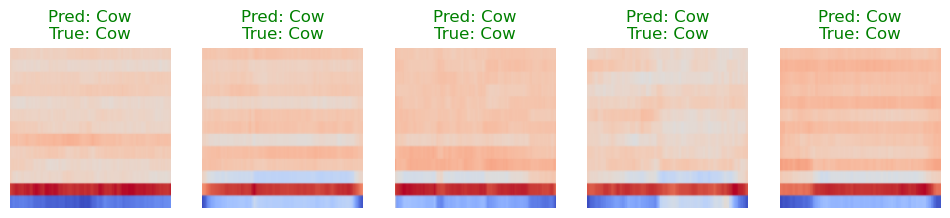

In [30]:
import matplotlib.pyplot as plt
import numpy as np

# Function to display images with predictions
def show_predictions(model, data_loader, class_names, num_images=5):
    model.eval()  # Set model to evaluation mode
    images_shown = 0
    
    fig, axes = plt.subplots(1, num_images, figsize=(12, 4))
    
    with torch.no_grad():
        for images, labels in data_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, preds = torch.max(outputs, 1)  # Get predicted class
            
            for i in range(num_images):
                image = images[i].cpu().numpy().transpose((1, 2, 0))  # Convert tensor to image
                image = (image * 0.5) + 0.5  # Denormalize

                axes[i].imshow(image)
                axes[i].axis('off')
                axes[i].set_title(f"Pred: {class_names[preds[i]]}\nTrue: {class_names[labels[i]]}",
                                  color=("green" if preds[i] == labels[i] else "red"))

                images_shown += 1
                if images_shown == num_images:
                    break
            if images_shown == num_images:
                break
                
    plt.show()

# Call the function to visualize predictions
show_predictions(model, test_loader, dataset.classes, num_images=5)
